# Fake News Detector

## Import Library

In [1]:
import os
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [2]:
true = pd.read_csv('True.csv', engine='python', encoding='utf-8', on_bad_lines='skip')
fake = pd.read_csv('Fake.csv', engine='python', encoding='utf-8', on_bad_lines='skip')

In [3]:
true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
true['label'] = 1
fake['label'] = 0

# Data Preprocessing

## Data Integration

In [6]:
news = pd.concat([fake, true], axis=0)

In [7]:
news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
news.tail()

,title,text,subject,date,label
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


## Data Cleaning

### Checking Null Values

In [9]:
news.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

### Dropping Unnecessary Column

In [10]:
news = news.drop(['title', 'subject', 'date'], axis=1)

In [11]:
news

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",1
21414,MINSK (Reuters) - In the shadow of disused Sov...,1
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,1


### Scramble Data

In [12]:
news = news.sample(frac=1)
news.reset_index(inplace=True)
news.drop(['index'], axis = 1, inplace=True)

In [13]:
news

,text,label
0,WASHINGTON (Reuters) - U.S. Senate Republicans...,1
1,It s always interesting when people decide to ...,0
2,You won t believe this judge and how he berate...,0
3,NEW YORK (Reuters) - U.S. President-elect Dona...,1
4,WASHINGTON (Reuters) - Utah Republicans on Wed...,1
...,...,...
44893,"Lawyers working on behalf of Roger Ailes, the ...",0
44894,BAGHDAD (Reuters) - Iraqi Prime Minister Haide...,1
44895,NEW DELHI (Reuters) - Indian Prime Minister Na...,1
44896,HONG KONG (Reuters) - For anyone digging into ...,1


### WordOPT

In [14]:
def wordopt(text):
    # Convert into lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|\www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d', '', text)

    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    return text

## Stopwords and Stemming

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [17]:
def tokenize_no_stemming(text):
    words = word_tokenize(text.lower())
    processed_words = [word for word in words if word not in stop_words]
    return processed_words

def tokenize_with_stemming(text):
    words = word_tokenize(text.lower())
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return processed_words

## Split Data

In [18]:
x = news['text']
y = news['label']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model

## Logistic Regression Model

### Initializing Models: Logistic Regression

In [20]:
tf_idf_LR = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_no_stemming)),
    ('log_reg', LogisticRegression())
])

stem_LR = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('log_reg', LogisticRegression())
])

full_LR = ImbPipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('scaler', StandardScaler(with_mean=False)),
    ('log_reg', LogisticRegression(class_weight='balanced'))
])

In [21]:
tf_idf_LR.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_no_stemming at 0x0000018273BAE440>)),
                ('log_reg', LogisticRegression())])

In [22]:
stem_LR.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('log_reg', LogisticRegression())])

In [23]:
full_LR.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('log_reg', LogisticRegression(class_weight='balanced'))])

#### Model Evaluation: Logistic Regression

In [24]:
tf_idf_train_pred_lr = tf_idf_LR.predict(x_train)
tf_idf_test_pred_lr = tf_idf_LR.predict(x_test)

In [25]:
stem_train_pred_lr = stem_LR.predict(x_train)
stem_test_pred_lr = stem_LR.predict(x_test)

In [26]:
full_train_pred_lr = full_LR.predict(x_train)
full_test_pred_lr = full_LR.predict(x_test)

##### Classification Report

In [27]:
print(classification_report(y_train, tf_idf_train_pred_lr))
print(classification_report(y_test, tf_idf_test_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [28]:
print(classification_report(y_train, stem_train_pred_lr))
print(classification_report(y_test, stem_test_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [29]:
print(classification_report(y_train, full_train_pred_lr))
print(classification_report(y_test, full_test_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4628
           1       0.99      1.00      0.99      4352

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



##### Confusion Matrix

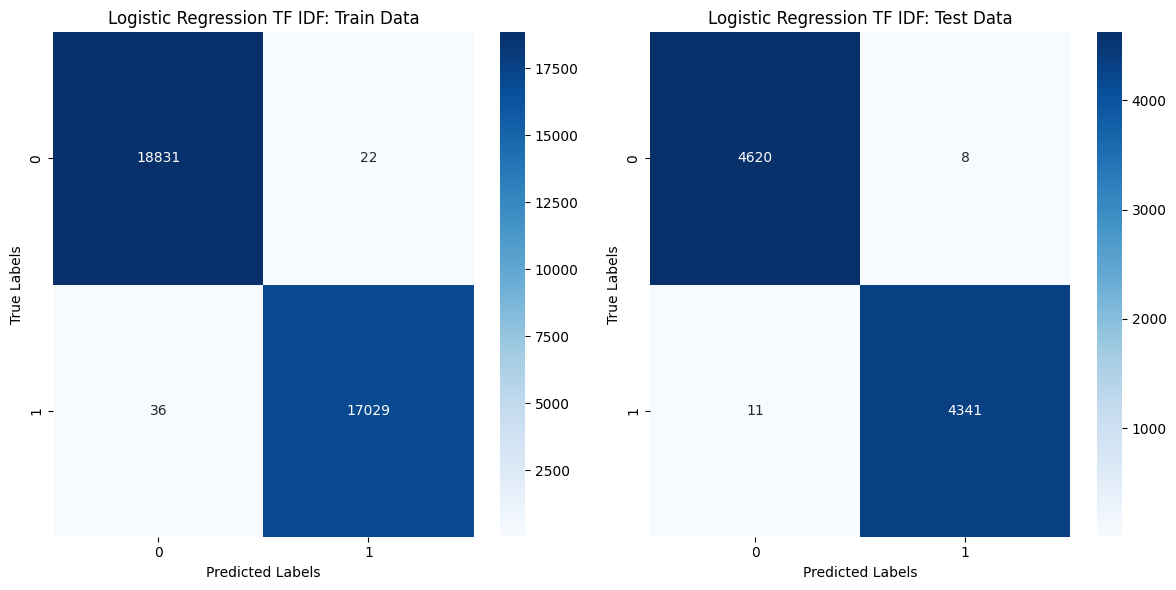

In [30]:

tf_idf_train_pred_LR_confusion_matrix = confusion_matrix(y_train, tf_idf_train_pred_lr)
tf_idf_test_pred_LR_confusion_matrix = confusion_matrix(y_test, tf_idf_test_pred_lr)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(tf_idf_train_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression TF IDF: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(tf_idf_test_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression TF IDF: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

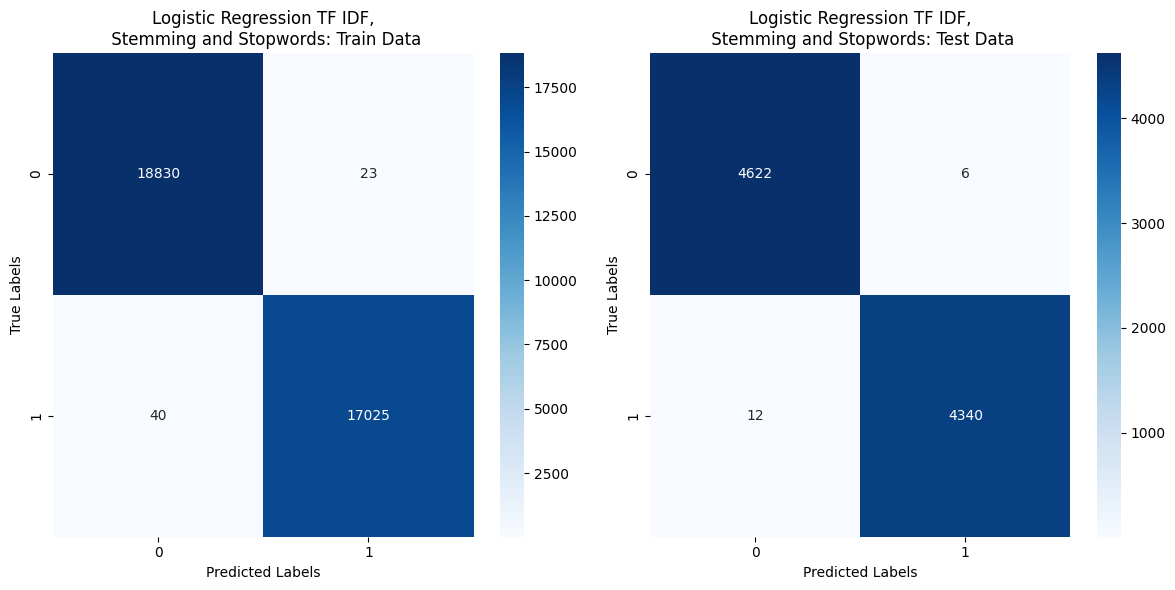

In [31]:

stem_train_pred_LR_confusion_matrix = confusion_matrix(y_train, stem_train_pred_lr)
stem_test_pred_LR_confusion_matrix = confusion_matrix(y_test, stem_test_pred_lr)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(stem_train_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression TF IDF,\n Stemming and Stopwords: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(stem_test_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression TF IDF,\n Stemming and Stopwords: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


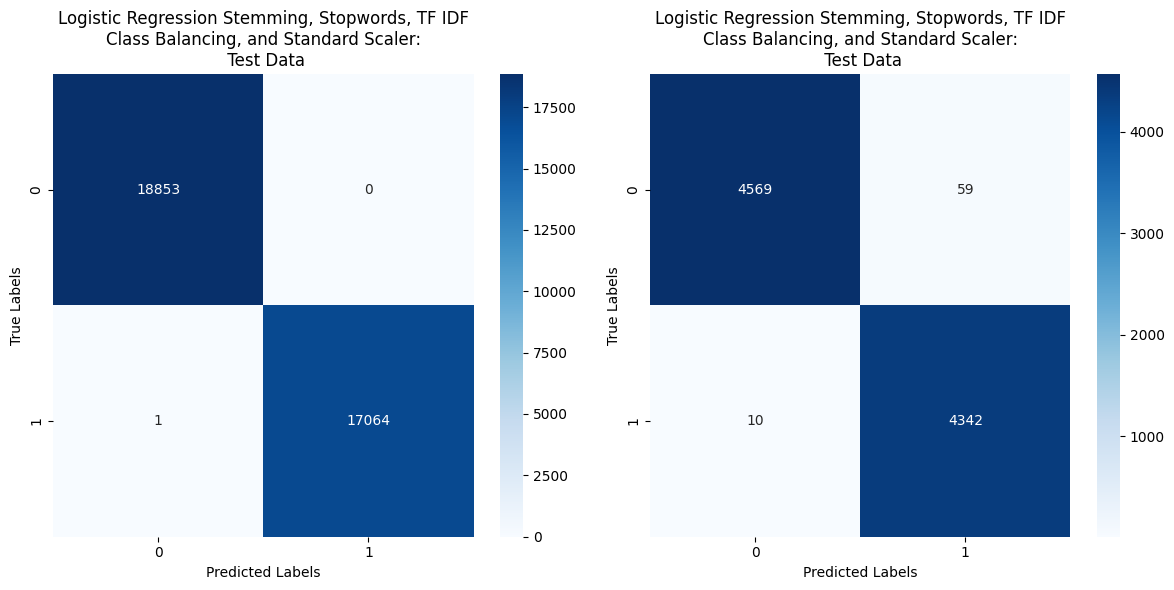

In [32]:

full_train_pred_LR_confusion_matrix = confusion_matrix(y_train, full_train_pred_lr)
full_test_pred_LR_confusion_matrix = confusion_matrix(y_test, full_test_pred_lr)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(full_train_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression Stemming, Stopwords, TF IDF\nClass Balancing, and Standard Scaler:\n Test Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(full_test_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Logistic Regression Stemming, Stopwords, TF IDF\nClass Balancing, and Standard Scaler:\n Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

##### Logistic Regression Score

In [33]:
tf_idf_train_score_LR = tf_idf_LR.score(x_train, y_train)
tf_idf_test_score_LR = tf_idf_LR.score(x_test, y_test)

stem_train_score_LR = stem_LR.score(x_train, y_train)
stem_test_score_LR = stem_LR.score(x_test, y_test)

full_train_score_LR = full_LR.score(x_train, y_train)
full_test_score_LR = full_LR.score(x_test, y_test)

##### Model Comparison (Logistic Regression)

In [34]:
LR_models_train_score = [
    ('Logistic Regression TF IDF (Train Score)', tf_idf_train_score_LR, tf_idf_LR),
    ('Logistic Regression Stemming, Stopwords, TF IDF (Train Score)', stem_train_score_LR, stem_LR),
    ('Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score)', full_train_score_LR, full_LR),
]

LR_models_test_score = [
    ('Logistic Regression TF IDF (Test Score)', tf_idf_test_score_LR, tf_idf_LR),
    ('Logistic Regression Stemming, Stopwords, TF IDF (Test Score)', stem_test_score_LR, stem_LR),
    ('Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Test Score)', full_test_score_LR, full_LR),
]

LR_models_train_score_sorted = sorted(LR_models_train_score, key=lambda x: x[1], reverse=True)
LR_models_test_score_sorted = sorted(LR_models_test_score, key=lambda x: x[1], reverse=True)

# Percentage differentials for training scores
LR_max_train_score = LR_models_train_score_sorted[0][1]
LR_train_percentage_differentials = [(model[1] - LR_max_train_score) / LR_max_train_score * 100 for model in LR_models_train_score_sorted]

# Percentage differentials for test scores
LR_max_test_score = LR_models_test_score_sorted[0][1]
LR_test_percentage_differentials = [(model[1] - LR_max_test_score) / LR_max_test_score * 100 for model in LR_models_test_score_sorted]

print("\nModel Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(LR_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({LR_train_percentage_differentials[rank-1]:.2f}%)")

print("\nModel Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(LR_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({LR_test_percentage_differentials[rank-1]:.2f}%)")


Model Rankings based on Train Accuracy:
1. Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score) -> 0.99997 (0.00%)
2. Logistic Regression TF IDF (Train Score) -> 0.99839 (-0.16%)
3. Logistic Regression Stemming, Stopwords, TF IDF (Train Score) -> 0.99825 (-0.17%)

Model Rankings based on Test Accuracy:
1. Logistic Regression Stemming, Stopwords, TF IDF (Test Score) -> 0.99800 (0.00%)
2. Logistic Regression TF IDF (Test Score) -> 0.99788 (-0.01%)
3. Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Test Score) -> 0.99232 (-0.57%)


### Logistic Regression Hyperparameter Optimization

#### GridSearchCV

In [196]:
# GridSearchCV Parameters
LR_param_grid = {
    'log_reg__C': [0.1, 1.0, 10.0],
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__solver': ['liblinear', 'saga'],
    'log_reg__max_iter': [1000, 5000]
}

In [ ]:
# TF IDF GridSearchCV
tf_idf_LR_random_search = GridSearchCV(estimator=tf_idf_LR, param_grid=LR_param_grid, cv=5, scoring='accuracy', n_jobs=4)
tf_idf_LR_random_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=4,
             param_grid={'log_reg__C': [0.1, 1.0, 10.0],
                         'log_reg__max_iter': [1000, 5000],
                         'log_reg__penalty': ['l1', 'l2'],
                         'log_reg__solver': ['liblinear', 'saga'],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [ ]:
# TF-IDF with Stemming & Stopwords GridSearchCV
stem_LR_random_search = GridSearchCV(estimator=stem_LR, param_grid=LR_param_grid, cv=5, scoring='accuracy', n_jobs=4)
stem_LR_random_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=4,
             param_grid={'log_reg__C': [0.1, 1.0, 10.0],
                         'log_reg__max_iter': [1000, 5000],
                         'log_reg__penalty': ['l1', 'l2'],
                         'log_reg__solver': ['liblinear', 'saga'],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [199]:
# TF-IDF with Stemming, Stopwords, Class Balancing, and Standard Scaler GridSearchCV
full_LR_random_search = GridSearchCV(estimator=full_LR, param_grid=LR_param_grid, cv=5, scoring='accuracy', n_jobs=4)
full_LR_random_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('log_reg',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=4,
             param_grid={'log_reg__C': [10.0], 'log_reg__max_iter': [1000],
                         'log_reg__penalty': ['l1'],
                         'log_reg__solver': ['liblinear']},
             scoring='accuracy')

In [201]:
# Best Parameters
print(f"Best parameters for TF IDF Logistic Regression: {tf_idf_LR_random_search.best_params_}")
print(f"Best parameters for Stemming and Stopwords Logistic Regression: {stem_LR_random_search.best_params_}")
print(f"Best parameters for Stemming, Stopwords, Class Balancing, and Standard Scaler Logistic Regression: {full_LR_random_search.best_params_}")

Best parameters for TF IDF Logistic Regression: {'log_reg__C': 10.0, 'log_reg__max_iter': 5000, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best parameters for Stemming and Stopwords Logistic Regression: {'log_reg__C': 10.0, 'log_reg__max_iter': 1000, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best parameters for Stemming, Stopwords, Class Balancing, and Standard Scaler Logistic Regression: {'log_reg__C': 10.0, 'log_reg__max_iter': 1000, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}


#### Initializing Models: Logistic Regression Model After GridSearchCV

In [35]:
optimized_tf_idf_LR = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_no_stemming)),
    ('log_reg', LogisticRegression())
])

optimized_stem_LR = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('log_reg', LogisticRegression())
])

optimized_full_LR = ImbPipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('scaler', StandardScaler(with_mean=False)),
    ('log_reg', LogisticRegression(class_weight='balanced'))
])

In [36]:
optimized_tf_idf_LR.set_params(
    log_reg__C=10.0,
    log_reg__max_iter=5000,
    log_reg__penalty='l1',
    log_reg__solver='liblinear'
)

optimized_stem_LR.set_params(
    log_reg__C=10.0,
    log_reg__max_iter=1000,
    log_reg__penalty='l1',
    log_reg__solver='liblinear'
)

optimized_full_LR.set_params(
    log_reg__C=10.0,
    log_reg__max_iter=1000,
    log_reg__penalty='l1',
    log_reg__solver='liblinear'
)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('log_reg',
                 LogisticRegression(C=10.0, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [37]:
optimized_tf_idf_LR.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_no_stemming at 0x0000018273BAE440>)),
                ('log_reg',
                 LogisticRegression(C=10.0, max_iter=5000, penalty='l1',
                                    solver='liblinear'))])

In [38]:
optimized_stem_LR.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('log_reg',
                 LogisticRegression(C=10.0, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [39]:
optimized_full_LR.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('log_reg',
                 LogisticRegression(C=10.0, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

##### Model Evaluation: Optimized Logistic Regression

In [40]:
optimized_tf_idf_train_pred_LR = optimized_tf_idf_LR.predict(x_train)
optimized_tf_idf_test_pred_LR = optimized_tf_idf_LR.predict(x_test)

In [41]:
optimized_stem_train_pred_LR = optimized_stem_LR.predict(x_train)
optimized_stem_test_pred_LR = optimized_stem_LR.predict(x_test)

In [42]:
optimized_full_train_pred_LR = optimized_full_LR.predict(x_train)
optimized_full_test_pred_LR = optimized_full_LR.predict(x_test)

###### Classification Report

In [43]:
print(classification_report(y_train, optimized_tf_idf_train_pred_LR))
print(classification_report(y_test, optimized_tf_idf_test_pred_LR))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [44]:
print(classification_report(y_train, optimized_stem_train_pred_LR))
print(classification_report(y_test, optimized_stem_test_pred_LR))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [45]:
print(classification_report(y_train, optimized_full_train_pred_LR))
print(classification_report(y_test, optimized_full_test_pred_LR))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



###### Confusion Matrix

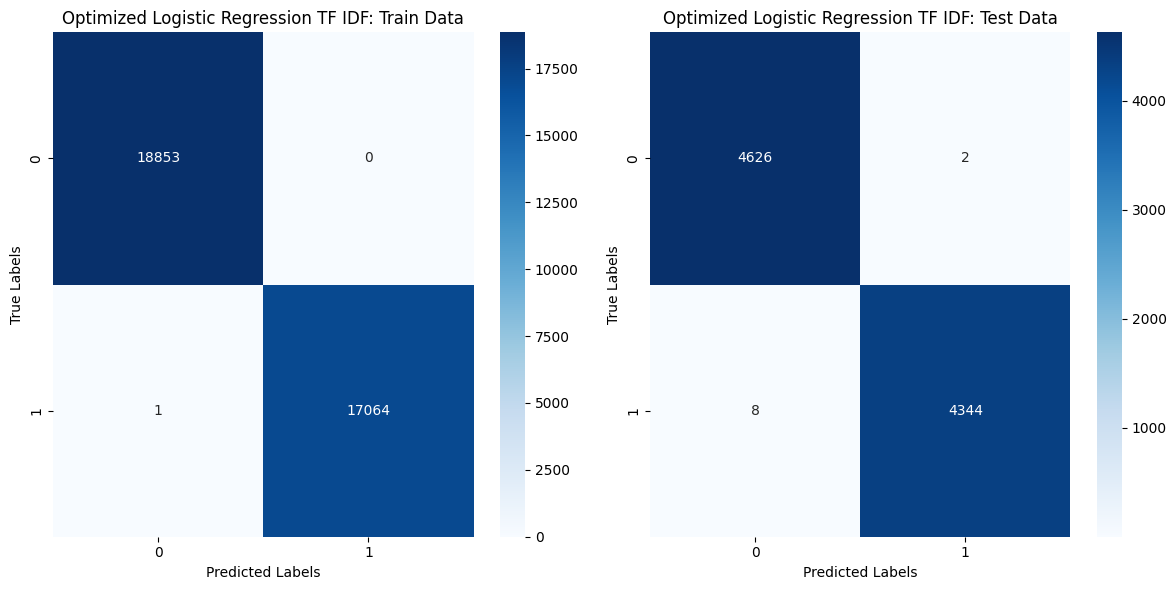

In [46]:
optimized_tf_idf_train_pred_LR_confusion_matrix = confusion_matrix(y_train, optimized_tf_idf_train_pred_LR)
optimized_tf_idf_test_pred_LR_confusion_matrix = confusion_matrix(y_test, optimized_tf_idf_test_pred_LR)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(optimized_tf_idf_train_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Optimized Logistic Regression TF IDF: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(optimized_tf_idf_test_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Optimized Logistic Regression TF IDF: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

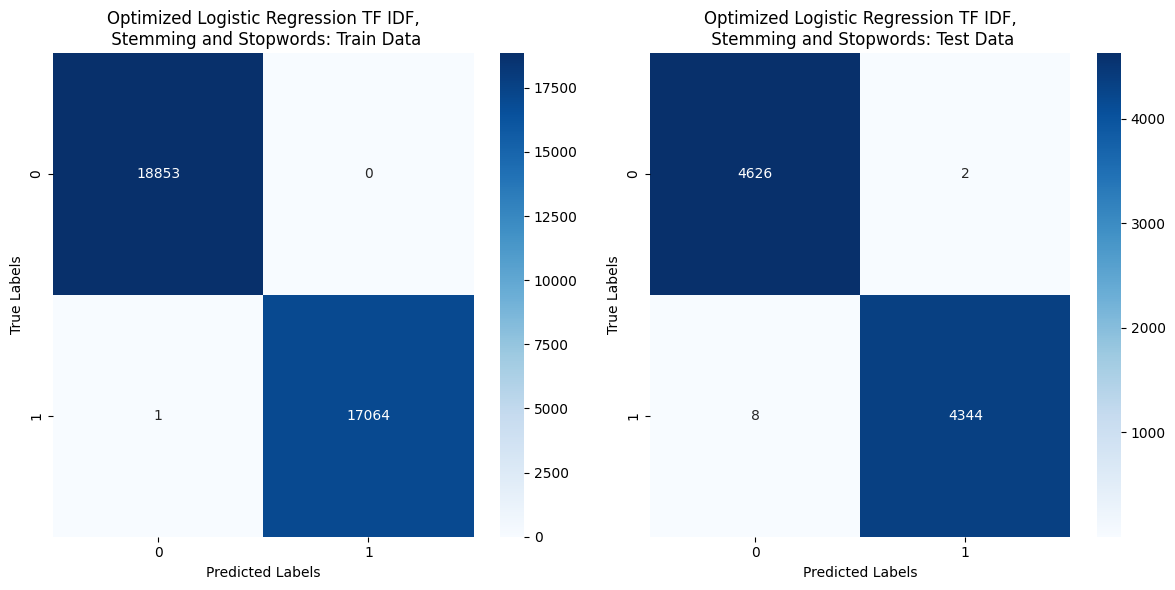

In [47]:

optimized_stem_train_pred_LR_confusion_matrix = confusion_matrix(y_train, optimized_stem_train_pred_LR)
optimized_stem_test_pred_LR_confusion_matrix = confusion_matrix(y_test, optimized_stem_test_pred_LR)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(optimized_stem_train_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Optimized Logistic Regression TF IDF,\n Stemming and Stopwords: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(optimized_stem_test_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Optimized Logistic Regression TF IDF,\n Stemming and Stopwords: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

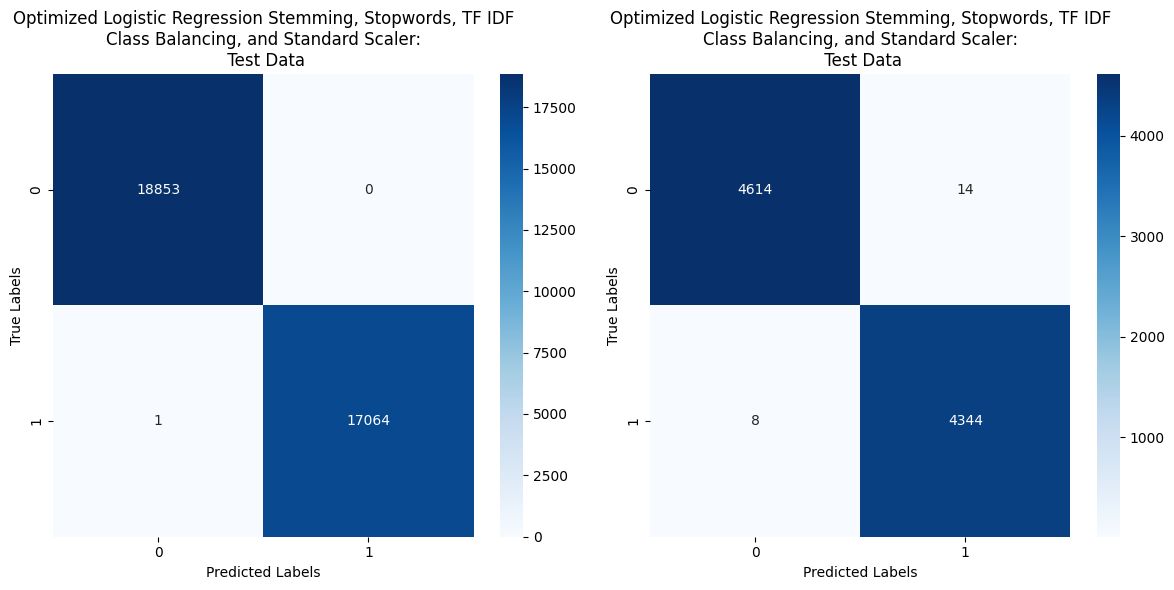

In [48]:
optimized_full_train_pred_LR_confusion_matrix = confusion_matrix(y_train, optimized_full_train_pred_LR)
optimized_full_test_pred_LR_confusion_matrix = confusion_matrix(y_test, optimized_full_test_pred_LR)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(optimized_full_train_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Optimized Logistic Regression Stemming, Stopwords, TF IDF\nClass Balancing, and Standard Scaler:\n Test Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(optimized_full_test_pred_LR_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Optimized Logistic Regression Stemming, Stopwords, TF IDF\nClass Balancing, and Standard Scaler:\n Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

###### Optimized Logistic Regression Score

In [49]:
optimized_tf_idf_train_score_LR = optimized_tf_idf_LR.score(x_train, y_train)
optimized_tf_idf_test_score_LR = optimized_tf_idf_LR.score(x_test, y_test)

optimized_stem_train_score_LR = optimized_stem_LR.score(x_train, y_train)
optimized_stem_test_score_LR = optimized_stem_LR.score(x_test, y_test)

optimized_full_train_score_LR = optimized_full_LR.score(x_train, y_train)
optimized_full_test_score_LR = optimized_full_LR.score(x_test, y_test)

###### Model Comparison (Optimized Logistic Regression)

In [50]:
LR_optimized_models_train_score = [
    ('Optimized Logistic Regression TF IDF (Train Score)', optimized_tf_idf_train_score_LR, optimized_tf_idf_LR),
    ('Optimized Logistic Regression Stemming, Stopwords, TF IDF (Train Score)', optimized_stem_train_score_LR, optimized_stem_LR),
    ('Optimized Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score)', optimized_full_train_score_LR, optimized_full_LR)
]

LR_optimized_models_test_score = [
    ('Optimized Logistic Regression TF IDF (Test Score)', optimized_tf_idf_test_score_LR, optimized_tf_idf_LR),
    ('Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score)', optimized_stem_test_score_LR, optimized_stem_LR),
    ('Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score), Class Balancing, and Standard Scaler', optimized_full_test_score_LR, optimized_full_LR)
]

LR_optimized_models_train_score_sorted = sorted(LR_optimized_models_train_score, key=lambda x: x[1], reverse=True)
LR_optimized_models_test_score_sorted = sorted(LR_optimized_models_test_score, key=lambda x: x[1], reverse=True)

LR_optimized_max_train_score = LR_optimized_models_train_score_sorted[0][1]
LR_optimized_train_percentage_differentials = [(model[1] - LR_optimized_max_train_score) / LR_optimized_max_train_score * 100 for model in LR_optimized_models_train_score_sorted]

LR_max_test_score = LR_optimized_models_test_score_sorted[0][1]
LR_test_percentage_differentials = [(model[1] - LR_max_test_score) / LR_max_test_score * 100 for model in LR_optimized_models_test_score_sorted]

print("\nOptimized Model Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(LR_optimized_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({LR_optimized_train_percentage_differentials[rank-1]:.2f}%)")

print("\nOptimized Model Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(LR_optimized_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({LR_test_percentage_differentials[rank-1]:.2f}%)")


Optimized Model Rankings based on Train Accuracy:
1. Optimized Logistic Regression TF IDF (Train Score) -> 0.99997 (0.00%)
2. Optimized Logistic Regression Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
3. Optimized Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score) -> 0.99997 (0.00%)

Optimized Model Rankings based on Test Accuracy:
1. Optimized Logistic Regression TF IDF (Test Score) -> 0.99889 (0.00%)
2. Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score) -> 0.99889 (0.00%)
3. Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score), Class Balancing, and Standard Scaler -> 0.99755 (-0.13%)


### Models Rankings: Logistic Regression

In [51]:
LR_combined_models_train_score = LR_models_train_score + LR_optimized_models_train_score
LR_combined_models_test_score = LR_models_test_score + LR_optimized_models_test_score

LR_combined_models_train_score_sorted = sorted(LR_combined_models_train_score, key=lambda x: x[1], reverse=True)
LR_combined_models_test_score_sorted = sorted(LR_combined_models_test_score, key=lambda x: x[1], reverse=True)

LR_combined_max_train_score = LR_combined_models_train_score_sorted[0][1]
LR_combined_train_percentage_differentials = [(model[1] - LR_combined_max_train_score) / LR_combined_max_train_score * 100 for model in LR_combined_models_train_score_sorted]

LR_combined_max_test_score = LR_combined_models_test_score_sorted[0][1]
LR_combined_test_percentage_differentials = [(model[1] - LR_combined_max_test_score) / LR_combined_max_test_score * 100 for model in LR_combined_models_test_score_sorted]

print("\nOptimized Model Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(LR_combined_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({LR_combined_train_percentage_differentials[rank-1]:.2f}%)")

print("\nOptimized Model Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(LR_combined_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({LR_combined_test_percentage_differentials[rank-1]:.2f}%)")


Optimized Model Rankings based on Train Accuracy:
1. Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score) -> 0.99997 (0.00%)
2. Optimized Logistic Regression TF IDF (Train Score) -> 0.99997 (0.00%)
3. Optimized Logistic Regression Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
4. Optimized Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score) -> 0.99997 (0.00%)
5. Logistic Regression TF IDF (Train Score) -> 0.99839 (-0.16%)
6. Logistic Regression Stemming, Stopwords, TF IDF (Train Score) -> 0.99825 (-0.17%)

Optimized Model Rankings based on Test Accuracy:
1. Optimized Logistic Regression TF IDF (Test Score) -> 0.99889 (0.00%)
2. Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score) -> 0.99889 (0.00%)
3. Logistic Regression Stemming, Stopwords, TF IDF (Test Score) -> 0.99800 (-0.09%)
4. Logistic Regression TF IDF (Test Score) -> 0.99788 (-0.10%)
5. Optimized Logi

## Decision Tree Classifier Model

### Initializing Models: Decision Tree Classifier

In [52]:
tf_idf_DTC = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_no_stemming)),
    ('dtc', DecisionTreeClassifier())
])

stem_DTC = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('dtc', DecisionTreeClassifier())
])

full_DTC = ImbPipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('dtc', DecisionTreeClassifier(class_weight='balanced'))
])

In [53]:
tf_idf_DTC.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_no_stemming at 0x0000018273BAE440>)),
                ('dtc', DecisionTreeClassifier())])

In [54]:
stem_DTC.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('dtc', DecisionTreeClassifier())])

In [55]:
full_DTC.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('dtc', DecisionTreeClassifier(class_weight='balanced'))])

### Model Evaluation: Decision Tree Classifier

In [56]:
tf_idf_train_pred_DTC = tf_idf_DTC.predict(x_train)
tf_idf_test_pred_DTC = tf_idf_DTC.predict(x_test)

In [57]:
stem_train_pred_DTC = stem_DTC.predict(x_train)
stem_test_pred_DTC = stem_DTC.predict(x_test)

In [58]:
full_train_pred_DTC = full_DTC.predict(x_train)
full_test_pred_DTC = full_DTC.predict(x_test)

#### Classification Report

In [59]:
print(classification_report(y_train, tf_idf_train_pred_DTC))
print(classification_report(y_test, tf_idf_test_pred_DTC))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [60]:
print(classification_report(y_train, stem_train_pred_DTC))
print(classification_report(y_test, stem_test_pred_DTC))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [61]:
print(classification_report(y_train, full_train_pred_DTC))
print(classification_report(y_test, full_test_pred_DTC))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



#### Confusion Matrix

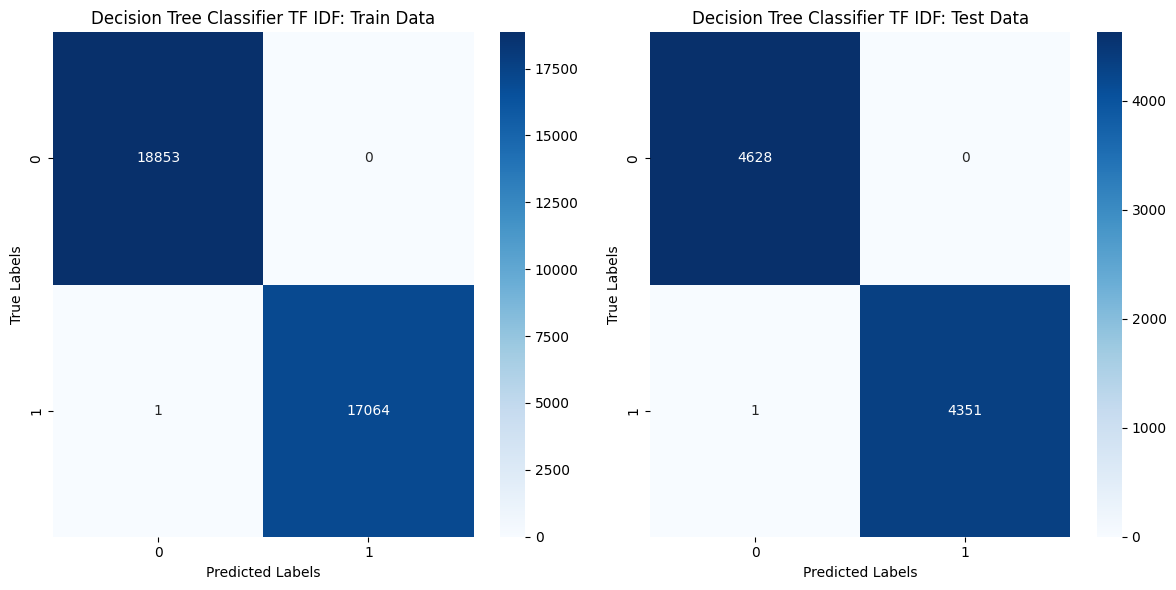

In [62]:
tf_idf_train_pred_DTC_confusion_matrix = confusion_matrix(y_train, tf_idf_train_pred_DTC)
tf_idf_test_pred_DTC_confusion_matrix = confusion_matrix(y_test, tf_idf_test_pred_DTC)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(tf_idf_train_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Decision Tree Classifier TF IDF: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(tf_idf_test_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Decision Tree Classifier TF IDF: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()



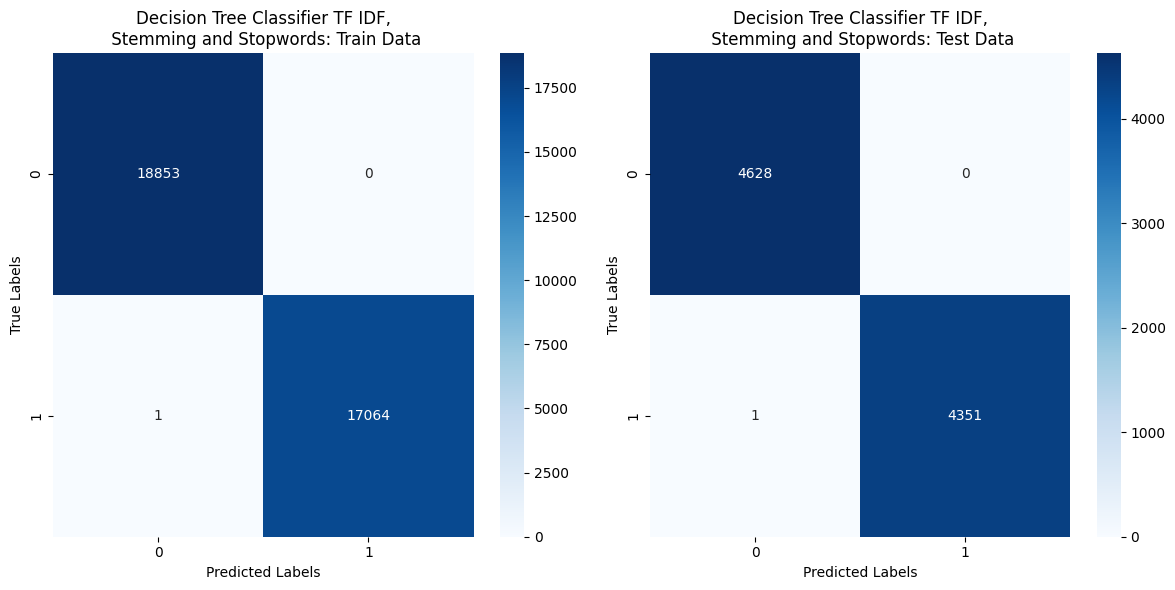

In [63]:
stem_train_pred_DTC_confusion_matrix = confusion_matrix(y_train, stem_train_pred_DTC)
stem_test_pred_DTC_confusion_matrix = confusion_matrix(y_test, stem_test_pred_DTC)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(stem_train_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Decision Tree Classifier TF IDF,\n Stemming and Stopwords: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(stem_test_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Decision Tree Classifier TF IDF,\n Stemming and Stopwords: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()



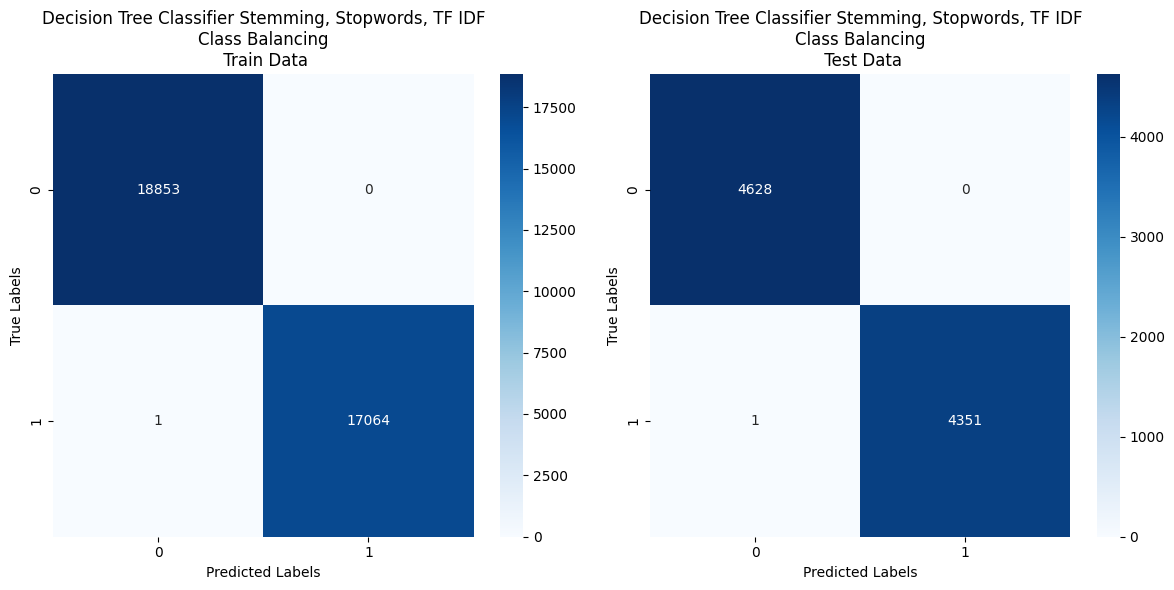

In [64]:

full_train_pred_DTC_confusion_matrix = confusion_matrix(y_train, full_train_pred_DTC)
full_test_pred_DTC_confusion_matrix = confusion_matrix(y_test, full_test_pred_DTC)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(full_train_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Decision Tree Classifier Stemming, Stopwords, TF IDF\nClass Balancing\n Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(full_test_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Decision Tree Classifier Stemming, Stopwords, TF IDF\nClass Balancing\n Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

#### Decision Tree Classifier Score

In [65]:
tf_idf_train_score_DTC = tf_idf_DTC.score(x_train, y_train)
tf_idf_test_score_DTC = tf_idf_DTC.score(x_test, y_test)

stem_train_score_DTC = stem_DTC.score(x_train, y_train)
stem_test_score_DTC = stem_DTC.score(x_test, y_test)

full_train_score_DTC = full_DTC.score(x_train, y_train)
full_test_score_DTC = full_DTC.score(x_test, y_test)

#### Model Comparison

In [66]:
DTC_models_train_score = [
    ('Decision Tree Classifier TF IDF (Train Score)', tf_idf_train_score_DTC, tf_idf_DTC),
    ('Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score)', stem_train_score_DTC, stem_DTC),
    ('Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score)', full_train_score_DTC, full_DTC),
]

DTC_models_test_score = [
    ('Decision Tree Classifier TF IDF (Test Score)', tf_idf_test_score_DTC, tf_idf_DTC),
    ('Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score)', stem_test_score_DTC, stem_DTC),
    ('Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score)', full_test_score_DTC, full_DTC),
]

DTC_models_train_score_sorted = sorted(DTC_models_train_score, key=lambda x: x[1], reverse=True)
DTC_models_test_score_sorted = sorted(DTC_models_test_score, key=lambda x: x[1], reverse=True)

DTC_max_train_score = DTC_models_train_score_sorted[0][1]
DTC_train_percentage_differentials = [(model[1] - DTC_max_train_score) / DTC_max_train_score * 100 for model in DTC_models_train_score_sorted]

DTC_max_test_score = DTC_models_test_score_sorted[0][1]
DTC_test_percentage_differentials = [(model[1] - DTC_max_test_score) / DTC_max_test_score * 100 for model in DTC_models_test_score_sorted]

print("\nModel Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(DTC_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({DTC_train_percentage_differentials[rank-1]:.2f}%)")

print("\nModel Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(DTC_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({DTC_test_percentage_differentials[rank-1]:.2f}%)")


Model Rankings based on Train Accuracy:
1. Decision Tree Classifier TF IDF (Train Score) -> 0.99997 (0.00%)
2. Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
3. Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score) -> 0.99997 (0.00%)

Model Rankings based on Test Accuracy:
1. Decision Tree Classifier TF IDF (Test Score) -> 0.99989 (0.00%)
2. Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score) -> 0.99989 (0.00%)
3. Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score) -> 0.99989 (0.00%)


### Decision Tree Classifier Hyperparameter Optimization

#### GridSearchCV

In [216]:
# GridSearchCV Parameters
param_grid_DTC = {
    'dtc__max_depth': [None, 5, 10, 20, 30, 40, 50],
    'dtc__min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'dtc__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]
}

In [ ]:
# TF-IDF GridSearchCV
tf_idf_grid_search_DTC = GridSearchCV(estimator=tf_idf_DTC, param_grid=param_grid_DTC, cv=5, scoring='accuracy', n_jobs=4)
tf_idf_grid_search_DTC.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=4,
             param_grid={'dtc__max_depth': [None], 'dtc__min_samples_leaf': [1],
                         'dtc__min_samples_split': [2]},
             scoring='accuracy')

In [ ]:
# TF-IDF with Stemming & Stopwords GridSearchCV
stem_grid_search_DTC = GridSearchCV(estimator=stem_DTC, param_grid=param_grid_DTC, cv=5, scoring='accuracy', n_jobs=4)
stem_grid_search_DTC.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=4,
             param_grid={'dtc__max_depth': [None], 'dtc__min_samples_leaf': [1],
                         'dtc__min_samples_split': [2]},
             scoring='accuracy')

In [217]:
# TF-IDF with Stemming, Stopwords, Class Balancing, and Standard Scaler GridSearchCV
full_grid_search_DTC = GridSearchCV(estimator=full_DTC, param_grid=param_grid_DTC, cv=2, scoring='accuracy', n_jobs=4)
full_grid_search_DTC.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dtc',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             n_jobs=4,
             param_grid={'dtc__max_depth': [None], 'dtc__min_samples_leaf': [1],
                         'dtc__min_samples_split': [2]},
             scoring='accuracy')

In [218]:
print(f"Best parameters for TF IDF Decision Tree Classifier: {tf_idf_grid_search_DTC.best_params_}")
print(f"Best parameters for Stem and Stopwords Decision Tree Classifier: {stem_grid_search_DTC.best_params_}")
print(f"Best parameters for Decision Tree Classifier Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler: {full_grid_search_DTC.best_params_}")

Best parameters for TF IDF Decision Tree Classifier: {'dtc__max_depth': None, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best parameters for Stem and Stopwords Decision Tree Classifier: {'dtc__max_depth': None, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best parameters for Decision Tree Classifier Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler: {'dtc__max_depth': None, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


#### Initializing Models: Decision Tree Classifier Model After GridSearchCV

In [67]:
optimized_tf_idf_DTC = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_no_stemming)),
    ('dtc', DecisionTreeClassifier(    
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2
    ))
])

optimized_stem_DTC = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('dtc', DecisionTreeClassifier(        
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2))
])

optimized_full_DTC = ImbPipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize_with_stemming)),
    ('dtc', DecisionTreeClassifier(
        class_weight='balanced',        
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2
        ))
])

In [68]:
optimized_tf_idf_DTC.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_no_stemming at 0x0000018273BAE440>)),
                ('dtc', DecisionTreeClassifier())])

In [69]:
optimized_stem_DTC.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('dtc', DecisionTreeClassifier())])

In [70]:
optimized_full_DTC.fit(x_train, y_train)

c:\Users\Kalea\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                ('dtc', DecisionTreeClassifier(class_weight='balanced'))])

##### Model Evaluation: Optimized Decision Tree Classifier

In [71]:
optimized_tf_idf_train_pred_DTC = optimized_tf_idf_DTC.predict(x_train)
optimized_tf_idf_test_pred_DTC = optimized_tf_idf_DTC.predict(x_test)

In [72]:
optimized_stem_train_pred_DTC = optimized_stem_DTC.predict(x_train)
optimized_stem_test_pred_DTC = optimized_stem_DTC.predict(x_test)

In [73]:
optimized_full_train_pred_DTC = optimized_full_DTC.predict(x_train)
optimized_full_test_pred_DTC = optimized_full_DTC.predict(x_test)

###### Classification Report

In [74]:
print(classification_report(y_train, tf_idf_train_pred_lr))
print(classification_report(y_test, tf_idf_test_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [75]:
print(classification_report(y_train, optimized_stem_train_pred_DTC))
print(classification_report(y_test, optimized_stem_test_pred_DTC))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [76]:
print(classification_report(y_train, optimized_full_train_pred_DTC))
print(classification_report(y_test, optimized_full_test_pred_DTC))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18853
           1       1.00      1.00      1.00     17065

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4628
           1       1.00      1.00      1.00      4352

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



###### Confusion Matrix

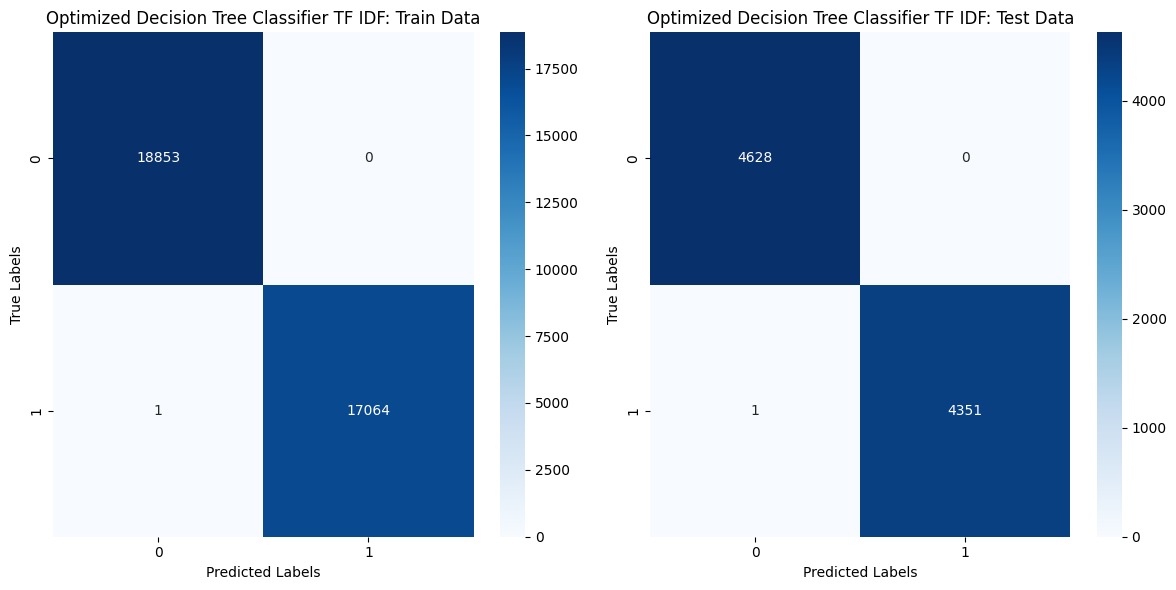

In [77]:
optimized_tf_idf_train_pred_DTC_confusion_matrix = confusion_matrix(y_train, optimized_tf_idf_train_pred_DTC)
optimized_tf_idf_test_pred_DTC_confusion_matrix = confusion_matrix(y_test, optimized_tf_idf_test_pred_DTC)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(optimized_tf_idf_train_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Optimized Decision Tree Classifier TF IDF: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(optimized_tf_idf_test_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Optimized Decision Tree Classifier TF IDF: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


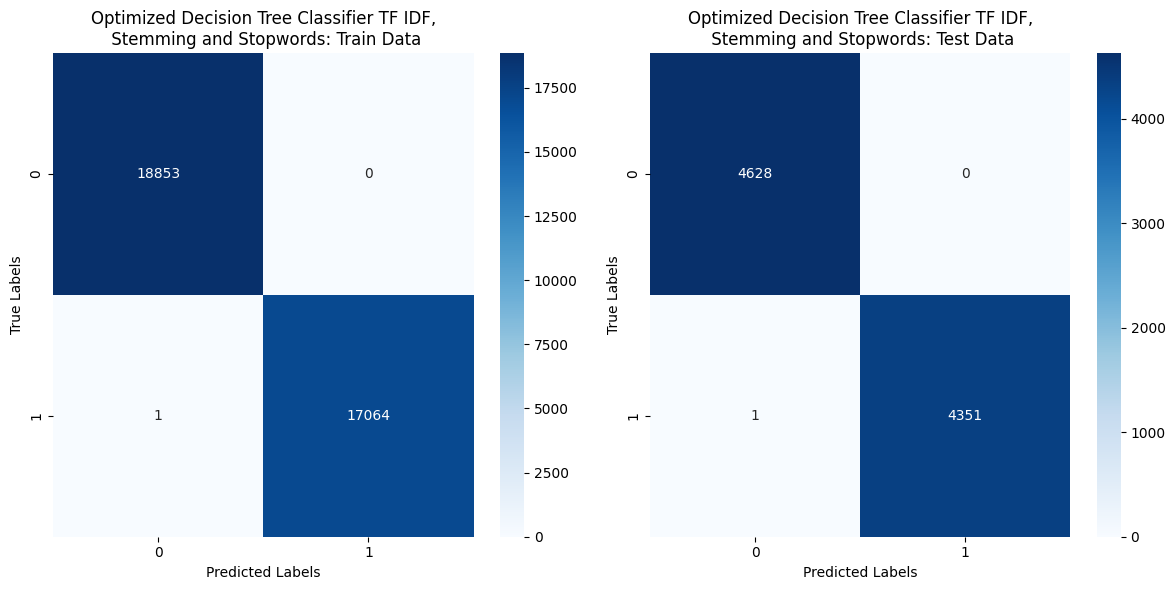

In [100]:


optimized_stem_train_pred_DTC_confusion_matrix = confusion_matrix(y_train, optimized_stem_train_pred_DTC)
optimized_stem_test_pred_DTC_confusion_matrix = confusion_matrix(y_test, optimized_stem_test_pred_DTC)

# Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(optimized_stem_train_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Optimized Decision Tree Classifier TF IDF,\n Stemming and Stopwords: Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(optimized_stem_test_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Optimized Decision Tree Classifier TF IDF,\n Stemming and Stopwords: Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

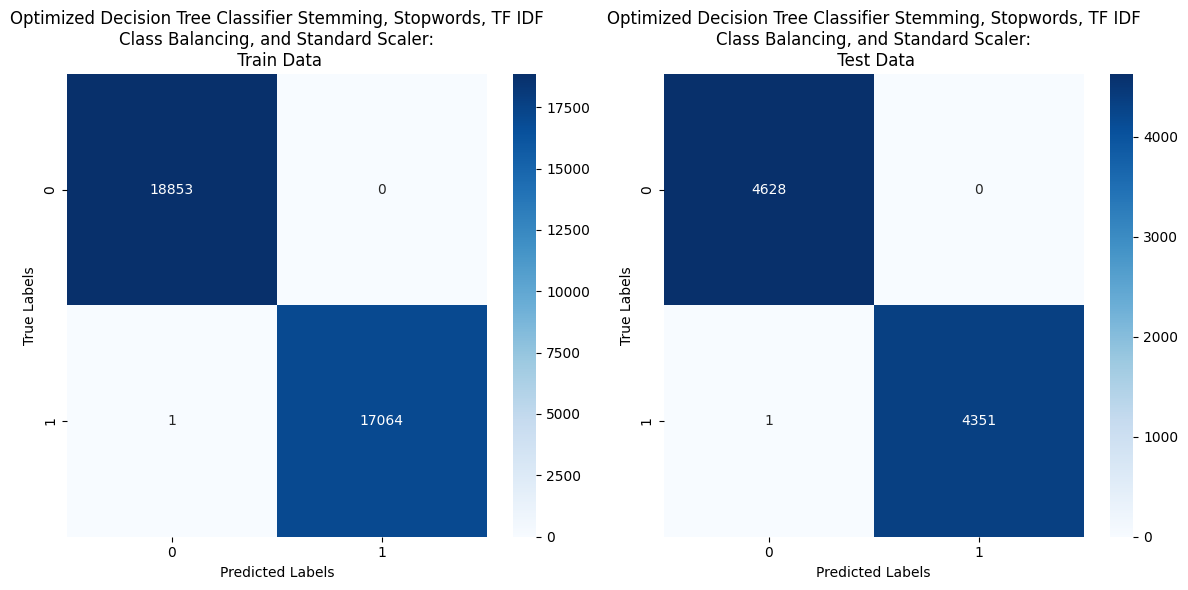

In [79]:

optimized_full_train_pred_DTC_confusion_matrix = confusion_matrix(y_train, optimized_full_train_pred_DTC)
optimized_full_test_pred_DTC_confusion_matrix = confusion_matrix(y_test, optimized_full_test_pred_DTC)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training data confusion matrix
sns.heatmap(optimized_full_train_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF\nClass Balancing, and Standard Scaler:\n Train Data')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test data confusion matrix
sns.heatmap(optimized_full_test_pred_DTC_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF\nClass Balancing, and Standard Scaler:\n Test Data')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

###### Optimized Decision Tree Classifier Score

In [80]:
optimized_tf_idf_train_score_DTC = optimized_tf_idf_DTC.score(x_train, y_train)
optimized_tf_idf_test_score_DTC = optimized_tf_idf_DTC.score(x_test, y_test)

optimized_stem_train_score_DTC = optimized_stem_DTC.score(x_train, y_train)
optimized_stem_test_score_DTC = optimized_stem_DTC.score(x_test, y_test)

optimized_full_train_score_DTC = optimized_full_DTC.score(x_train, y_train)
optimized_full_test_score_DTC = optimized_full_DTC.score(x_test, y_test)


###### Model Comparison (Optimized Logistic Regression)

In [81]:
DTC_optimized_models_train_score = [
    ('Optimized Decision Tree Classifier TF IDF (Train Score)', optimized_tf_idf_train_score_DTC, optimized_tf_idf_DTC),
    ('Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score)', optimized_stem_train_score_DTC, optimized_stem_DTC),
    ('Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score)', optimized_full_train_score_DTC, optimized_full_DTC),
]

DTC_optimized_models_test_score = [
    ('Optimized Decision Tree Classifier TF IDF (Test Score)', optimized_tf_idf_test_score_DTC, optimized_tf_idf_DTC),
    ('Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score)', optimized_stem_test_score_DTC, optimized_stem_DTC),
    ('Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score)', optimized_full_test_score_DTC, optimized_full_DTC),
]

DTC_optimized_models_train_score_sorted = sorted(DTC_optimized_models_train_score, key=lambda x: x[1], reverse=True)
DTC_optimized_models_test_score_sorted = sorted(DTC_optimized_models_test_score, key=lambda x: x[1], reverse=True)

DTC_optimized_max_train_score = DTC_optimized_models_train_score_sorted[0][1]
DTC_optimized_train_percentage_differentials = [(model[1] - DTC_optimized_max_train_score) / DTC_optimized_max_train_score * 100 for model in DTC_optimized_models_train_score_sorted]

DTC_optimized_max_test_score = DTC_optimized_models_test_score_sorted[0][1]
DTC_optimized_test_percentage_differentials = [(model[1] - DTC_optimized_max_test_score) / DTC_optimized_max_test_score * 100 for model in DTC_optimized_models_test_score_sorted]

print("\nModel Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(DTC_optimized_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({DTC_optimized_train_percentage_differentials[rank-1]:.2f}%)")

print("\nModel Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(DTC_optimized_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({DTC_optimized_test_percentage_differentials[rank-1]:.2f}%)")


Model Rankings based on Train Accuracy:
1. Optimized Decision Tree Classifier TF IDF (Train Score) -> 0.99997 (0.00%)
2. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
3. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score) -> 0.99997 (0.00%)

Model Rankings based on Test Accuracy:
1. Optimized Decision Tree Classifier TF IDF (Test Score) -> 0.99989 (0.00%)
2. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score) -> 0.99989 (0.00%)
3. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score) -> 0.99989 (0.00%)


### Models Rankings: Decision Tree Classifier

In [82]:
DTC_combined_models_train_score = DTC_models_train_score + DTC_optimized_models_train_score
DTC_combined_models_test_score = DTC_models_test_score + DTC_optimized_models_test_score

DTC_combined_models_train_score_sorted = sorted(DTC_combined_models_train_score, key=lambda x: x[1], reverse=True)
DTC_combined_models_test_score_sorted = sorted(DTC_combined_models_test_score, key=lambda x: x[1], reverse=True)

DTC_combined_max_train_score = DTC_combined_models_train_score_sorted[0][1]
DTC_combined_train_percentage_differentials = [(model[1] - DTC_combined_max_train_score) / DTC_combined_max_train_score * 100 for model in DTC_combined_models_train_score_sorted]

DTC_combined_max_test_score = DTC_combined_models_test_score_sorted[0][1]
DTC_combined_test_percentage_differentials = [(model[1] - DTC_combined_max_test_score) / DTC_combined_max_test_score * 100 for model in DTC_combined_models_test_score_sorted]

print("\nOptimized Model Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(DTC_combined_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({DTC_combined_train_percentage_differentials[rank-1]:.2f}%)")

print("\nOptimized Model Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(DTC_combined_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({DTC_combined_test_percentage_differentials[rank-1]:.2f}%)")


Optimized Model Rankings based on Train Accuracy:
1. Decision Tree Classifier TF IDF (Train Score) -> 0.99997 (0.00%)
2. Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
3. Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score) -> 0.99997 (0.00%)
4. Optimized Decision Tree Classifier TF IDF (Train Score) -> 0.99997 (0.00%)
5. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
6. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score) -> 0.99997 (0.00%)

Optimized Model Rankings based on Test Accuracy:
1. Decision Tree Classifier TF IDF (Test Score) -> 0.99989 (0.00%)
2. Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score) -> 0.99989 (0.00%)
3. Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score) -> 0.99989 (0.00%)
4. Optimized Decision Tree Classifier TF IDF (Test Score) -> 0.99989 (0

## Logistic Regression and Decision Tree Classifier Model Rankings

In [91]:
all_models_train_score = LR_combined_models_train_score + DTC_combined_models_train_score
all_models_test_score = LR_combined_models_test_score + DTC_combined_models_test_score

all_models_train_score_sorted = sorted(all_models_train_score, key=lambda x: x[1], reverse=True)
all_models_test_score_sorted = sorted(all_models_test_score, key=lambda x: x[1], reverse=True)

all_models_train_score = all_models_train_score_sorted[0][1]
all_models_train_percentage_differentials = [(model[1] - all_models_train_score) / all_models_train_score * 100 for model in all_models_train_score_sorted]

all_models_max_test_score = all_models_test_score_sorted[0][1]
all_models_test_percentage_differentials = [(model[1] - all_models_max_test_score) / all_models_max_test_score * 100 for model in all_models_test_score_sorted]

print("\nModel Rankings based on Train Accuracy:")
for rank, (desc, score, model) in enumerate(all_models_train_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({all_models_train_percentage_differentials[rank-1]:.2f}%)")

print("\nModel Rankings based on Test Accuracy:")
for rank, (desc, score, model) in enumerate(all_models_test_score_sorted, start=1):
    print(f"{rank}. {desc} -> {score:.5f} ({all_models_test_percentage_differentials[rank-1]:.2f}%)")


Model Rankings based on Train Accuracy:
1. Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score) -> 0.99997 (0.00%)
2. Optimized Logistic Regression TF IDF (Train Score) -> 0.99997 (0.00%)
3. Optimized Logistic Regression Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
4. Optimized Logistic Regression Stemming, Stopwords, TF IDF, Class Balancing, and Standard Scaler (Train Score) -> 0.99997 (0.00%)
5. Decision Tree Classifier TF IDF (Train Score) -> 0.99997 (0.00%)
6. Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
7. Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train Score) -> 0.99997 (0.00%)
8. Optimized Decision Tree Classifier TF IDF (Train Score) -> 0.99997 (0.00%)
9. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Train Score) -> 0.99997 (0.00%)
10. Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Train

# Model Implementation

In [84]:
def output_label(n):
  if n==0:
    return "Fake News"
  elif n==1:
    return "Genuine News"

In [85]:
all_models_test_score_sorted

[('Decision Tree Classifier TF IDF (Test Score)',
  0.9998886414253898,
  Pipeline(steps=[('tfidf',
                   TfidfVectorizer(tokenizer=<function tokenize_no_stemming at 0x0000018273BAE440>)),
                  ('dtc', DecisionTreeClassifier())])),
 ('Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score)',
  0.9998886414253898,
  Pipeline(steps=[('tfidf',
                   TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                  ('dtc', DecisionTreeClassifier())])),
 ('Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score)',
  0.9998886414253898,
  Pipeline(steps=[('tfidf',
                   TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                  ('dtc', DecisionTreeClassifier(class_weight='balanced'))])),
 ('Optimized Decision Tree Classifier TF IDF (Test Score)',
  0.9998886414253898,
  Pipeline(steps=[('tfidf',
                   TfidfVe

In [145]:
best_model = all_models_test_score_sorted[0][2]

In [146]:
best_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function tokenize_no_stemming at 0x0000018273BAE440>)),
                ('dtc', DecisionTreeClassifier())])

In [151]:
def manual_testing(news_text, model):
    # Ensure the input is a pandas Series
    new_def_test = pd.Series([news_text])

    # Apply the preprocessing function
    new_x_test = new_def_test.apply(wordopt)  # Take the first value

    # Model predictions
    for best_model in all_models_test_score_sorted:        
        pred = model.predict(new_x_test)

        # Print the prediction
        print(best_model[0])
        print(f"Prediction: {output_label(pred[0])}\n")



In [154]:
news_article = str(input())
manual_testing(news_article, best_model)

Decision Tree Classifier TF IDF (Test Score)
Prediction: Fake News

Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score)
Prediction: Fake News

Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score)
Prediction: Fake News

Optimized Decision Tree Classifier TF IDF (Test Score)
Prediction: Fake News

Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score)
Prediction: Fake News

Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score)
Prediction: Fake News

Optimized Logistic Regression TF IDF (Test Score)
Prediction: Fake News

Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score)
Prediction: Fake News

Logistic Regression Stemming, Stopwords, TF IDF (Test Score)
Prediction: Fake News

Logistic Regression TF IDF (Test Score)
Prediction: Fake News

Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score), Class Balancing, and Standard Scaler
Prediction: F

In [195]:
news_article = str(input())
manual_testing(news_article, best_model)

Text: Republicans are working overtime trying to sell their scam of a tax bill to the public as something that directly targets middle-class and working-class families with financial relief. Nothing could be further from the truth, and they re getting hammered on that repeatedly. Speaking on CNBC, Paul Ryan was going full throttle, trying to convince us that the paltry savings we re getting is actually wait for it big money.But he didn t just go with the usual talking points. With a smug look that only someone who grew up in a wealthy family can muster when talking about that which he does not know, Ryan claimed that the $2,059 more per year that families living paycheck-to-paycheck will see is extremely significant. Then he decided he had to amend that to say such savings might be nothing to a family earning $600,000 per year (true), or for people living in New York or California (false).Those are the same two states that Trump s loyal subjects insist on stripping from the 2016 vote t

In [110]:
def manual_testing(news, all_models_test_score_sorted):
    # Create a DataFrame with the news text
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)

    # Apply the preprocessing function
    new_x_test = new_def_test["text"].apply(wordopt).tolist()

    # Model predictions
    for best_model in all_models_test_score_sorted:
        # Get the vectorizer and transform the text
        vectorizer = best_model[2].named_steps['tfidf']
        vectorized_text = vectorizer.transform(new_x_test)
        
        # Get the classifier and predict
        classifier = best_model[2].named_steps.get('dtc', None) or best_model[2].named_steps.get('log_reg', None)
        if classifier is None:
            print(f"Unknown classifier in model: {best_model[0]}")
            continue
        
        pred = classifier.predict(vectorized_text)

        # Print the prediction
        print(best_model[0])
        print(f"Prediction: {output_label(pred[0])}\n")


In [137]:
news_article = x_test.iloc[0]
manual_testing(news_article, all_models_test_score_sorted)

<class 'str'>


AttributeError: 'tuple' object has no attribute 'predict'

In [139]:
y_test_pred = tf_idf_DTC.predict(x_test) 

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Confusion Matrix:
 [[4628    0]
 [   1 4351]]


In [142]:
type(x_test)

pandas.core.series.Series

In [115]:
x_test.iloc[0]

'PARIS (Reuters) - One French soldier from the 13th regiment of para-troopers was killed on Saturday morning while fighting in the Iraq-Syria region, the French Presidency said on Saturday.  The President has learned with great sadness of the death in the Levant this morning of a (soldier) ... killed in fighting,  Macron s office said in a statement. '

In [94]:
for i in range(len(all_models_test_score_sorted)):
    print(all_models_test_score_sorted[i][0], all_models_test_score_sorted[i][1])

Decision Tree Classifier TF IDF (Test Score) 0.9998886414253898
Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score) 0.9998886414253898
Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score) 0.9998886414253898
Optimized Decision Tree Classifier TF IDF (Test Score) 0.9998886414253898
Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score) 0.9998886414253898
Optimized Decision Tree Classifier Stemming, Stopwords, TF IDF, and Class Balancing (Test Score) 0.9998886414253898
Optimized Logistic Regression TF IDF (Test Score) 0.9988864142538976
Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score) 0.9988864142538976
Logistic Regression Stemming, Stopwords, TF IDF (Test Score) 0.9979955456570155
Logistic Regression TF IDF (Test Score) 0.9978841870824053
Optimized Logistic Regression Stemming, Stopwords, TF IDF (Test Score), Class Balancing, and Standard Scaler 0.9975501113585746
Logistic Regression Stemming, Stop

In [96]:
debug_model = all_models_test_score_sorted[1]
debug_model

('Decision Tree Classifier Stemming, Stopwords, TF IDF (Test Score)',
 0.9998886414253898,
 Pipeline(steps=[('tfidf',
                  TfidfVectorizer(tokenizer=<function tokenize_with_stemming at 0x000001822ECBD000>)),
                 ('dtc', DecisionTreeClassifier())]))

In [97]:
import numpy as np

# Assuming your decision tree classifier is named `dtc`
feature_importances = debug_model[2].named_steps['dtc'].feature_importances_

# Get feature names from the TF-IDF vectorizer
feature_names = debug_model[2].named_steps['tfidf'].get_feature_names_out()

# Combine feature names with their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

for feature, importance in sorted_features[:10]:  # Display top 10 features
    print(f"Feature: {feature}, Importance: {importance}")


Feature: -, Importance: 0.9917581951900032
Feature: reuter, Importance: 0.004234620711356642
Feature: ’, Importance: 0.002341617270654782
Feature: ”, Importance: 0.001139004263768094
Feature: parliament, Importance: 0.00041471437296171636
Feature: tobago, Importance: 0.00011163605569518874
Feature: ., Importance: 8.498494277241475e-08
Feature: :, Importance: 4.183987531621034e-08
Feature: !, Importance: 3.7961349386763794e-08
Feature: ,, Importance: 1.8840572388816024e-08


In [98]:
x_train[0]

'WASHINGTON (Reuters) - U.S. Senate Republicans were considering a raft of last-minute changes to their sweeping tax bill on Friday, as they edged toward a final vote that could move Congress to year-end enactment of tax cuts for businesses and individuals. Deals include a higher tax deduction for owners of pass-through businesses and a phase-out of full expensing for business capital investments.  To pay for these changes, Republicans say they will no longer repeal the alternative minimum taxes for corporations and individuals and will raise tax rates on the repatriation of corporate profits held overseas. Senate Republicans have yet to unveil a final bill for adoption. But here is an unofficial list of anticipated changes, according to lawmakers and lobbyists.  * PASS-THROUGHS: Senators Ron Johnson and Steve Daines announced their support for the tax bill after securing agreement on a bigger tax break for the owners of pass-through enterprises, including small businesses, S-corporati

In [99]:
import numpy as np
from sklearn.tree import _tree

# Assuming `x_test_stem` is the test set
# Select an instance (e.g., the first instance from the test set)
instance = x_test[0]

# Ensure the instance is in the correct shape (1, -1) for transformation
instance = np.array(instance).reshape(1, -1)

# Transform the instance using the TF-IDF vectorizer from the pipeline
transformed_instance = debug_model[2].named_steps['tfidf'].transform(instance)

# Get the decision path for the instance
node_indicator = debug_model[2].named_steps['dtc'].decision_path(transformed_instance)

# Get the leaf node id
leaf_id = debug_model[2].named_steps['dtc'].apply(transformed_instance)

# Get the feature and threshold values for the path
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
feature_names = debug_model[2].named_steps['tfidf'].get_feature_names_out()

for node_id in node_index:
    if leaf_id == node_id:
        continue

    # Feature used for the split
    feature = debug_model[2].named_steps['dtc'].tree_.feature[node_id]
    threshold = debug_model[2].named_steps['dtc'].tree_.threshold[node_id]

    # Ensure the feature is not the -2 indicator (which means it's not a split node)
    if feature != _tree.TREE_UNDEFINED:
        print(f"Node {node_id}: (Feature '{feature_names[feature]}' <= {threshold})")


KeyError: 0